# Pseudo batch transformation


## loading fedbatch data

In [36]:
import sys
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform, pseudobatch_transform_pandas
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

In [37]:
FIGURES_DIR = pathlib.Path('../figures')

In [38]:
# import the dataset from the article/data folder, this makes sure if the simulations are rerun the new data is used
data_path = pathlib.Path('../data/standard_fed-batch_process.csv')
fedbatch_df = _prepare_simulated_dataset(data_path)

To calculate the consumed glucose we require a measurement of the glucose concentration when the feeding is initiated (time 0). Here we assume that we have a measurement at time 0, but if a measurement is not available therefore several options:
1. Assume that initial glucose is 0. If the fed-batch is properly setup, the glucose concentration should be small at time 0. Thus, this assumption should not bias the results significantly. 
2. Estimate the concentration based on experience from similar batch cultures

As stated earlier fed-batch fermentations typically has a low substrate concentration when the feeding is initiated. 

The the initial glucose concentration typically constitute a small fraction of the substrate add over the hole course of the fed-batch process. Thus in most cases it is not crucial to have a very accurate estimate of the initial substrate concentration. One should be cautious if the feeding phase the short, or if the initial substrate concentration is significant compared to the substrate added through feeding.

In [39]:
# calculate consumed glucose
initial_m_glucose = fedbatch_df['m_Glucose'].iloc[0]
glucose_conc_in_feed = fedbatch_df.s_f.iloc[0] 
fedbatch_df['m_consumed_Glucose'] = initial_m_glucose + fedbatch_df['v_Feed_accum'] * glucose_conc_in_feed - fedbatch_df['m_Glucose']  

In [40]:
fedbatch_df_measurements_only = (fedbatch_df
    .query('sample_volume > 0')
    .copy()
)

In [41]:
y, X_noncorrected = dmatrices(formula_like = "np.log(m_Biomass) ~ timestamp", data= fedbatch_df_measurements_only)
model_noncorrected = sm.OLS(endog=y, exog=X_noncorrected)
res_noncorrected = model_noncorrected.fit()
mu_hat_noncorrected = res_noncorrected.params[1]
y_pred_noncorrected = res_noncorrected.predict(X_noncorrected)
print(mu_hat_noncorrected)

0.06597174185227486


# Calculate the growth rate using the pseudo batch transformation

Now we can calculate the corrected biomass using the pseudo batch transformation

In [42]:
## Calculates dilution factor and cummulative dilution factor

fedbatch_df["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df["sample_volume"].fillna(0).to_numpy(),
)
fedbatch_df_measurements_only["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

Now we use a linear model to fit the growth rate. To ease visualization we will fit the model the pseudo mass instead of the pseudo concentration.

$$
log(m_{corrected, \: Biomass}) = a + \mu * t
$$

In [49]:
# Calculate the pseudo mass of biomass
initial_volume = fedbatch_df['v_Volume'].iloc[0]
fedbatch_df_measurements_only['m_Biomass_pseudo'] = fedbatch_df_measurements_only['c_Biomass_pseudo'] * initial_volume

y, X_corrected = dmatrices(formula_like = "np.log(m_Biomass_pseudo) ~ timestamp", data= fedbatch_df_measurements_only)
model_corrected = sm.OLS(endog=y, exog=X_corrected)
res_corrected = model_corrected.fit()
mu_hat_corrected = res_corrected.params[1]
print("Fitted growth rate from corrected biomass: " + str(res_corrected.params[1]))

Fitted growth rate from corrected biomass: 0.10000016643815145


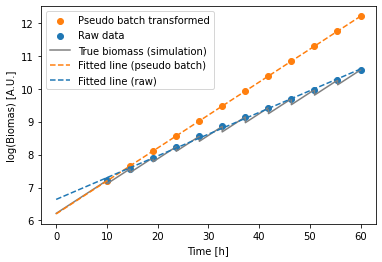

Fitted growth rate from pseudo batch transformed biomass: 0.10000016643815145
Fitted growth rate from raw biomass: 0.06597174185227486
True simulated growth rate 0.1000104046529978


<Figure size 254.88x254.88 with 0 Axes>

In [50]:
## plot the data and the fitted line
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['m_Biomass_pseudo'].transform(np.log), label='Pseudo batch transformed', color = "C1")
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['m_Biomass'].transform(np.log), label='Raw data', color = "C0")
plt.plot(fedbatch_df['timestamp'], fedbatch_df['m_Biomass'].transform(np.log), label='True biomass (simulation)', color='grey')

# Drawing linear regression line
x_pred = sm.add_constant(fedbatch_df['timestamp']) 
y_pred_pseudo = res_corrected.predict(x_pred)
y_pred_raw = res_noncorrected.predict(x_pred) 
plt.plot(fedbatch_df['timestamp'], y_pred_pseudo, color='C1', linestyle = 'dashed', label='Fitted line (pseudo batch)')
plt.plot(fedbatch_df['timestamp'], y_pred_raw, color='C0', linestyle = 'dashed', label='Fitted line (raw)')
plt.legend()
plt.ylabel("log(Biomas) [A.U.]")
plt.xlabel("Time [h]")
plt.show()

print("Fitted growth rate from pseudo batch transformed biomass: " + str(res_corrected.params[1]))
print("Fitted growth rate from raw biomass: " + str(res_noncorrected.params[1]))
print("True simulated growth rate " + str(fedbatch_df_measurements_only["mu_true"].iloc[-1]))
plt.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale.png", dpi=300)

# resize height and width of figure
fig = plt.gcf()
fig.set_size_inches((3.54, 3.54))
#fig.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0.)
fig.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale_paper.png", dpi=300)